In [15]:
# ============================================================================
# 导入所有必需的库和模块
# ============================================================================

# 基础库
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# API 和模型
from ambiguity_detection_utils import AmbiguityDetector
from ollama import Client
from prompts import DISAMBIGUATION_PROMPT_TEMPLATE, PSEUDOCODE_PROMPT_TEMPLATE

# 深度学习模型
import torch
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

# 机器学习评估指标
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score, 
    precision_recall_curve, auc,
    confusion_matrix, classification_report, 
    accuracy_score
)

print("所有库导入完成！")

所有库导入完成！


In [16]:
# ============================================================================
# 创建检测器和加载数据
# ============================================================================

# 创建语义歧义检测器
detector = AmbiguityDetector("semantic")

# 加载并准备数据
file_path = r"data/User Story Ambiguity Dataset_A Comprehensive Research Resource/Cornelius_2025_user_story_ambiguity_dataset.xlsx"
df_test = detector.load_and_prepare_data(file_path, create_balanced=True)

print(f"测试数据集: {len(df_test)} 个用户故事")

Semantic歧义统计:
  有semantic歧义: 2831 (22.0%)
  无semantic歧义: 10016 (78.0%)
平衡测试集: 5662 个用户故事
  HasAmbiguity=True: 2831 (50.0%)
  HasAmbiguity=False: 2831 (50.0%)
测试数据集: 5662 个用户故事


In [17]:
df_test = df_test.sample(n=100, random_state=42)
df_test.head()

,StoryID,StoryText,HasAmbiguity
5436,US-C7-12387,"As a store owner, I would like to search produ...",False
5102,US-C3-6378,"As a customer, I would like to handle orders t...",True
3694,US-C2-3975,"As a nurse, I want to process medical informat...",True
1499,US-C4-8257,"As a network admin, I would like to report out...",False
2698,US-C3-6132,"As a customer, I want to add to cart so that I...",False


In [18]:
df_test.count()

StoryID         100
StoryText       100
HasAmbiguity    100
dtype: int64

In [19]:
client = Client(
    host="http://2yo6159kw603.vicp.fun/",
)

In [20]:
prompt_template = DISAMBIGUATION_PROMPT_TEMPLATE

In [21]:
# 遍历df_test中的每个StoryText，使用prompt_template进行推理，并将结果存储为列表
results = []

for index, row in df_test.iterrows():
    story_text = row['StoryText']
    formatted_prompt = prompt_template.format(REQUIREMENT=story_text)
    
    try:
        response = client.chat(model='gpt-oss:20b', messages=[
            {
                'role': 'user',
                'content': formatted_prompt,
            },
        ])
        results.append({
            'StoryID': row['StoryID'],
            'StoryText': story_text,
            'HasAmbiguity': row['HasAmbiguity'],
            'Disambiguation': response.message.content
        })
        print(f"Processed story {index + 1}/{len(df_test)}: {row['StoryID']}")
    except Exception as e:
        print(f"Error processing story {row['StoryID']}: {str(e)}")
        results.append({
            'StoryID': row['StoryID'],
            'StoryText': story_text,
            'HasAmbiguity': row['HasAmbiguity'],
            'Disambiguation': f"Error: {str(e)}"
        })

print(f"\nCompleted processing {len(results)} stories.")

Processed story 5437/100: US-C7-12387
Processed story 5103/100: US-C3-6378
Processed story 3695/100: US-C2-3975
Processed story 1500/100: US-C4-8257
Processed story 2699/100: US-C3-6132
Processed story 4109/100: US-C1-550
Processed story 1033/100: US-C8-12543
Processed story 3297/100: US-C8-12509
Processed story 4282/100: US-C5-9581
Processed story 1671/100: US-C1-172
Processed story 3361/100: US-C2-2541
Processed story 677/100: US-C8-12670
Processed story 4879/100: US-C1-1194
Processed story 1860/100: US-C2-2813
Processed story 2139/100: US-C7-12305
Processed story 4517/100: US-C4-7741
Processed story 2060/100: US-C7-11398
Processed story 4703/100: US-C4-8428
Processed story 4732/100: US-C2-3577
Processed story 927/100: US-C5-10440
Processed story 102/100: US-C3-6708
Processed story 1316/100: US-C2-3205
Processed story 5305/100: US-C2-3601
Processed story 4314/100: US-C1-621
Processed story 169/100: US-C4-8197
Processed story 4630/100: US-C3-6231
Processed story 3442/100: US-C4-8731
P

In [22]:
# 解析消歧结果，将每个用户故事的消歧项转换为列表格式
parsed_results = []

for result in results:
    story_id = result['StoryID']
    story_text = result['StoryText']
    disambiguation_text = result['Disambiguation']
    
    # 解析消歧项
    disambiguations = []
    if disambiguation_text.startswith('Disambiguations:'):
        # 移除开头的'Disambiguations:'
        content = disambiguation_text[len('Disambiguations:'):].strip()
        # 按行分割
        lines = content.split('\n')
        for line in lines:
            line = line.strip()
            # 检查是否是以数字开头的消歧项
            if line and (line.startswith('1. ') or line.startswith('2. ') or line.startswith('3. ') 
                         or line.startswith('4. ') or line.startswith('5. ') or line.startswith('6. ') 
                         or line.startswith('7. ') or line.startswith('8. ') or line.startswith('9. ') 
                         or line.startswith('10. ')):
                # 提取消歧项内容（去掉序号）
                disambiguation = line.split('. ', 1)[1].strip()
                disambiguations.append(disambiguation)
    
    parsed_results.append({
        'StoryID': story_id,
        'StoryText': story_text,
        'Disambiguations': disambiguations
    })

# 显示解析后的结果
for parsed_result in parsed_results:
    print(f"用户故事: {parsed_result['StoryID']}")
    print(f"故事文本: {parsed_result['StoryText']}")
    print("消歧项列表:")
    for i, disambiguation in enumerate(parsed_result['Disambiguations'], 1):
        print(f"  {i}. {disambiguation}")
    print()

用户故事: US-C7-12387
故事文本: As a store owner, I would like to search products to make informed decisions
消歧项列表:
  1. As a store owner, I want to search products by name or SKU so that I can quickly locate items and evaluate their current inventory levels to decide on reordering.
  2. As a store owner, I want to search products by category and sub‑category so that I can analyze sales performance within each product line and identify high‑margin categories for focused promotion.
  3. As a store owner, I want to search products by price range and view their price history so that I can set competitive prices and determine optimal discount strategies.
  4. As a store owner, I want to search products by supplier and view supplier ratings, delivery lead times, and past reliability so that I can assess procurement options and negotiate better terms.
  5. As a store owner, I want to search products by inventory level (e.g., low stock, out of stock) so that I can prioritize restocking and prevent st

In [23]:
# 过滤掉澄清项为空的结果
parsed_results_filtered = [result for result in parsed_results if result['Disambiguations']]

print(f"原始结果数量: {len(parsed_results)}")
print(f"过滤后结果数量: {len(parsed_results_filtered)}")
print(f"已过滤掉的结果: {len(parsed_results) - len(parsed_results_filtered)}")

# 更新parsed_results为过滤后的结果
parsed_results = parsed_results_filtered

print("\n过滤完成，现在parsed_results只包含有澄清项的结果")

原始结果数量: 100
过滤后结果数量: 82
已过滤掉的结果: 18

过滤完成，现在parsed_results只包含有澄清项的结果


In [24]:
# 1. 加载预训练的BERT模型和分词器
model_name = "rambodazimi/bert-base-uncased-finetuned-FFT-QQP"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# 设置设备（GPU或CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()  # 设置为评估模式

print(f"BERT模型已加载到 {device}")
print(f"模型名称: {model_name}")

BERT模型已加载到 cpu
模型名称: rambodazimi/bert-base-uncased-finetuned-FFT-QQP


In [25]:
# 2. 定义获取句子嵌入的函数
def get_sentence_embedding(text, tokenizer, model, device, max_length=512):
    """
    获取文本的BERT嵌入向量
    
    参数:
        text: 输入文本
        tokenizer: BERT分词器
        model: BERT模型
        device: 计算设备 (cuda or cpu)
        max_length: 最大文本长度
    
    返回:
        embedding: 句子嵌入向量 (1, 768)
    """
    # 将文本转换为模型可接受的输入格式
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=max_length
    )
    
    # 将输入移到相同的设备上
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # 不计算梯度，加快推理速度
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 对最后一个隐藏层的所有标记向量求平均
    embedding = torch.mean(outputs.last_hidden_state, dim=1)
    
    return embedding.cpu().numpy()

print("get_sentence_embedding 函数已定义")

get_sentence_embedding 函数已定义


In [27]:
# 4. 定义计算 Clarification Score 的函数（核心方法）
def calculate_clarification_score(clarifications, tokenizer, model, device):
    """
    计算澄清批次的歧义分数
    
    公式: g(C_i^(q)) = ∑_{(c_ij, c_ij') ∈ C_i^(q) × C_i^(q)} (1 - sim(c_ij, c_ij'))
    
    该分数衡量澄清之间的语义分散程度。高分表示澄清之间差异大，
    说明原始查询具有高度歧义。低分表示澄清之间相似，说明原始查询较为明确。
    
    参数:
        clarifications: 澄清文本列表
        tokenizer: BERT分词器
        model: BERT模型
        device: 计算设备
    
    返回:
        score: 澄清分数（高分表示高歧义）
        similarity_matrix: 相似度矩阵 (n, n)
    """
    n = len(clarifications)
    
    if n < 2:
        # 如果少于2个澄清，无法计算分数
        return 0.0, np.array([[1.0]])
    
    # 1. 获取所有澄清的嵌入向量
    embeddings = []
    for clarification in clarifications:
        embedding = get_sentence_embedding(clarification, tokenizer, model, device)
        embeddings.append(embedding)
    
    embeddings = np.vstack(embeddings)  # (n, 768)
    
    # 2. 计算所有澄清对的相似度矩阵
    similarity_matrix = cosine_similarity(embeddings)  # (n, n)
    
    # 3. 计算分数：所有非对角线相似度倒数和
    score = 0.0
    pair_count = 0
    
    for i in range(n):
        for j in range(n):
            if i != j:  # 不包括自身相似度
                dissimilarity = 1 - similarity_matrix[i][j]
                score += dissimilarity
                pair_count += 1
    
    return score, similarity_matrix

print("calculate_clarification_score 函数已定义")

calculate_clarification_score 函数已定义


In [28]:
# 5. 处理解析后的结果，计算每个用户故事的 Clarification Score
clarification_scores = []

for idx, parsed_result in enumerate(parsed_results):
    story_id = parsed_result['StoryID']
    story_text = parsed_result['StoryText']
    disambiguations = parsed_result['Disambiguations']
    
    # 如果有澄清项，计算分数；否则分数为0
    if len(disambiguations) > 1:
        score, similarity_matrix = calculate_clarification_score(
            disambiguations, 
            tokenizer, 
            bert_model, 
            device
        )
    else:
        score = 0.0
        similarity_matrix = np.array([[1.0]])
    
    clarification_scores.append({
        'StoryID': story_id,
        'StoryText': story_text,
        'NumClarifications': len(disambiguations),
        'ClarificationScore': score,
        'AmbiguityLevel': 'High' if score > 5 else ('Medium' if score > 2 else 'Low')
    })
    
    print(f"已处理 {idx + 1}/{len(parsed_results)}: {story_id}")
    print(f"  澄清数: {len(disambiguations)}, 分数: {score:.4f}, 歧义级别: {clarification_scores[-1]['AmbiguityLevel']}")

# 创建DataFrame用于分析
scores_df = pd.DataFrame(clarification_scores)
print(f"\n完成处理 {len(clarification_scores)} 个用户故事")
print("\n澄清分数统计:")
print(scores_df[['NumClarifications', 'ClarificationScore', 'AmbiguityLevel']].describe())

已处理 1/82: US-C7-12387
  澄清数: 10, 分数: 3.9764, 歧义级别: Medium
已处理 2/82: US-C3-6378
  澄清数: 10, 分数: 5.1903, 歧义级别: High
已处理 3/82: US-C2-3975
  澄清数: 10, 分数: 4.8517, 歧义级别: Medium
已处理 4/82: US-C4-8257
  澄清数: 10, 分数: 2.8251, 歧义级别: Medium
已处理 5/82: US-C3-6132
  澄清数: 10, 分数: 5.7850, 歧义级别: High
已处理 6/82: US-C1-550
  澄清数: 10, 分数: 5.0182, 歧义级别: High
已处理 7/82: US-C8-12509
  澄清数: 10, 分数: 5.0834, 歧义级别: High
已处理 8/82: US-C1-172
  澄清数: 10, 分数: 4.7182, 歧义级别: Medium
已处理 9/82: US-C2-2541
  澄清数: 10, 分数: 4.3488, 歧义级别: Medium
已处理 10/82: US-C8-12670
  澄清数: 10, 分数: 4.9300, 歧义级别: Medium
已处理 11/82: US-C1-1194
  澄清数: 10, 分数: 5.2348, 歧义级别: High
已处理 12/82: US-C2-2813
  澄清数: 10, 分数: 4.8543, 歧义级别: Medium
已处理 13/82: US-C7-12305
  澄清数: 10, 分数: 4.1846, 歧义级别: Medium
已处理 14/82: US-C4-7741
  澄清数: 10, 分数: 4.3068, 歧义级别: Medium
已处理 15/82: US-C7-11398
  澄清数: 10, 分数: 3.7401, 歧义级别: Medium
已处理 16/82: US-C4-8428
  澄清数: 10, 分数: 3.1490, 歧义级别: Medium
已处理 17/82: US-C2-3577
  澄清数: 10, 分数: 6.0337, 歧义级别: High
已处理 18/82: US-C5-10440
  澄清数: 10

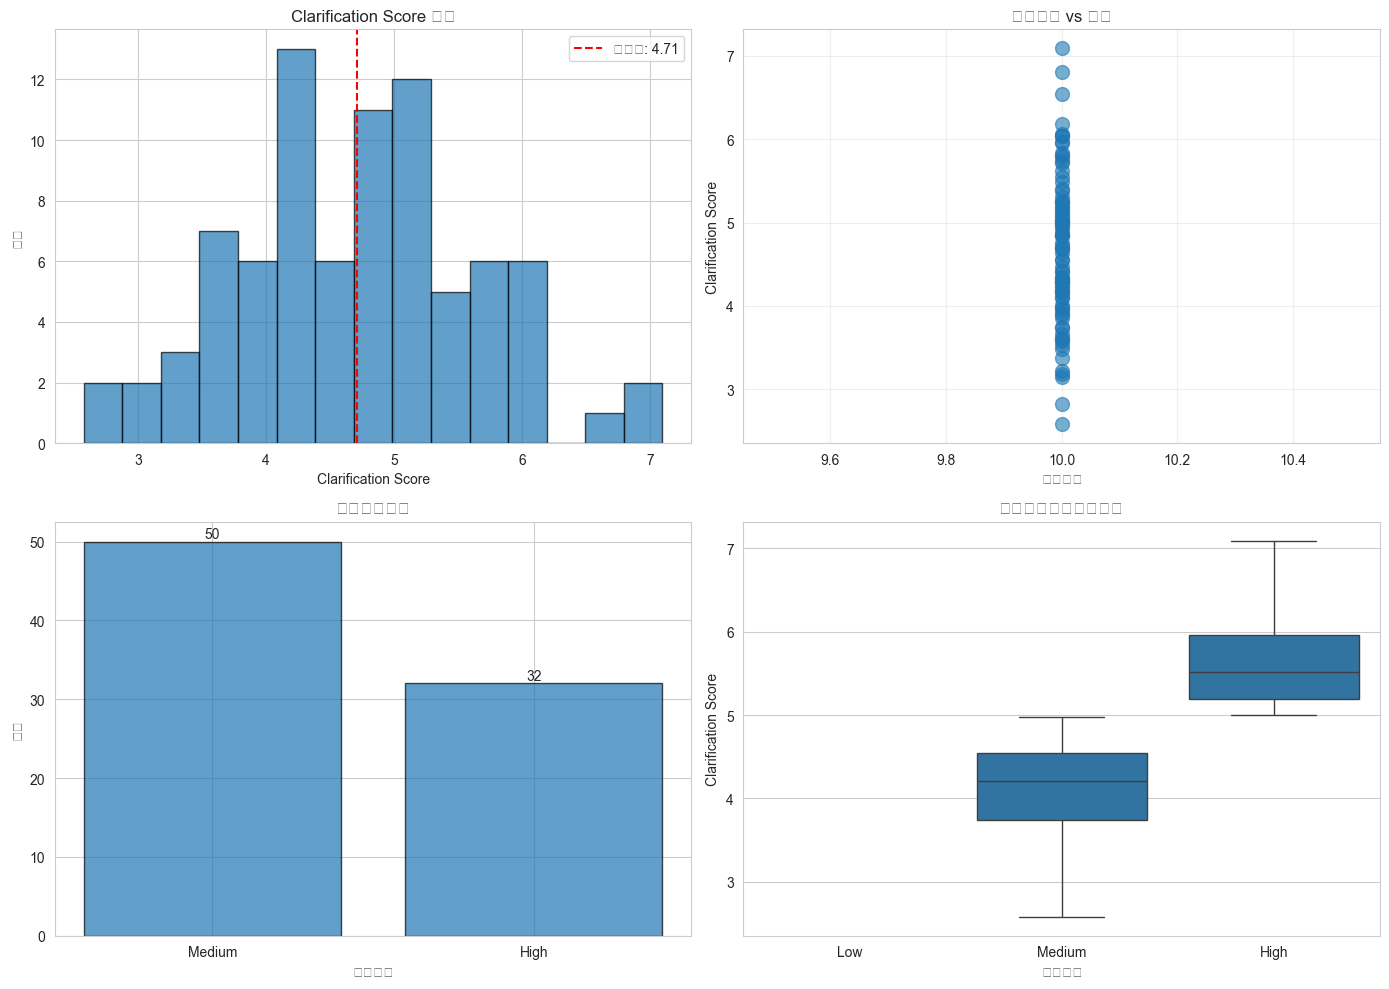

分析结果已保存到 clarification_score_analysis.png


In [29]:
# 6. 可视化分析结果
# 设置图表风格
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Clarification Score 分布直方图
axes[0, 0].hist(scores_df['ClarificationScore'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Clarification Score')
axes[0, 0].set_ylabel('频率')
axes[0, 0].set_title('Clarification Score 分布')
axes[0, 0].axvline(scores_df['ClarificationScore'].mean(), color='red', linestyle='--', label=f'平均值: {scores_df["ClarificationScore"].mean():.2f}')
axes[0, 0].legend()

# 2. 澄清数量 vs 分数散点图
axes[0, 1].scatter(scores_df['NumClarifications'], scores_df['ClarificationScore'], alpha=0.6, s=100)
axes[0, 1].set_xlabel('澄清数量')
axes[0, 1].set_ylabel('Clarification Score')
axes[0, 1].set_title('澄清数量 vs 分数')
axes[0, 1].grid(True, alpha=0.3)

# 3. 歧义级别分布
ambiguity_counts = scores_df['AmbiguityLevel'].value_counts()
axes[1, 0].bar(ambiguity_counts.index, ambiguity_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('歧义级别')
axes[1, 0].set_ylabel('数量')
axes[1, 0].set_title('歧义级别分布')
for i, v in enumerate(ambiguity_counts.values):
    axes[1, 0].text(i, v + 0.1, str(v), ha='center', va='bottom')

# 4. 评分箱线图（按歧义级别）
order = ['Low', 'Medium', 'High']
scores_df_sorted = scores_df.copy()
scores_df_sorted['AmbiguityLevel'] = pd.Categorical(scores_df_sorted['AmbiguityLevel'], categories=order, ordered=True)
sns.boxplot(data=scores_df_sorted, x='AmbiguityLevel', y='ClarificationScore', ax=axes[1, 1])
axes[1, 1].set_xlabel('歧义级别')
axes[1, 1].set_ylabel('Clarification Score')
axes[1, 1].set_title('各歧义级别的分数分布')

plt.tight_layout()
plt.savefig('clarification_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("分析结果已保存到 clarification_score_analysis.png")

In [30]:
# 8. 计算 AUROC 和 F1 分数用于评估歧义检测性能
# 合并 df_test 的真实标签和 scores_df 的预测分数
# 创建一个映射字典，将 StoryID 与 HasAmbiguity 对应
true_labels_dict = dict(zip(df_test['StoryID'], df_test['HasAmbiguity']))

# 为 scores_df 添加真实标签
scores_df['TrueLabel'] = scores_df['StoryID'].map(true_labels_dict)

# 移除没有真实标签的行
scores_df_with_labels = scores_df.dropna(subset=['TrueLabel'])

print(f"用于评估的样本数: {len(scores_df_with_labels)}")
print(f"真实标签分布:")
print(scores_df_with_labels['TrueLabel'].value_counts())
print()

# 准备数据
y_true = scores_df_with_labels['TrueLabel'].astype(int).values
y_scores = scores_df_with_labels['ClarificationScore'].values

# 1. 计算 AUROC
auroc = roc_auc_score(y_true, y_scores)
print(f"消歧方法 - AUROC: {auroc:.4f}")

# 获取ROC曲线的FPR和TPR
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)

# 2. 寻找最优的阈值（使用约登指数）
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = roc_thresholds[optimal_idx]

print(f"最优阈值（基于约登指数）: {optimal_threshold:.4f}")

# 3. 使用最优阈值进行二分类
y_pred = (y_scores >= optimal_threshold).astype(int)

# 4. 计算 F1 分数
f1 = f1_score(y_true, y_pred)
print(f"消歧方法 - F1 Score: {f1:.4f}")

# 5. 计算其他评估指标（用于可视化和后续分析，但不在主要输出中突出）
accuracy = accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# 6. Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

print("\n" + "="*50)
print(f"\n总结:")
print(f"  AUROC: {auroc:.4f}")
print(f"  F1 Score: {f1:.4f}\n")
print("="*50)

用于评估的样本数: 82
真实标签分布:
TrueLabel
True     46
False    36
Name: count, dtype: int64

消歧方法 - AUROC: 0.6455
最优阈值（基于约登指数）: 4.5471
消歧方法 - F1 Score: 0.7033


总结:
  AUROC: 0.6455
  F1 Score: 0.7033



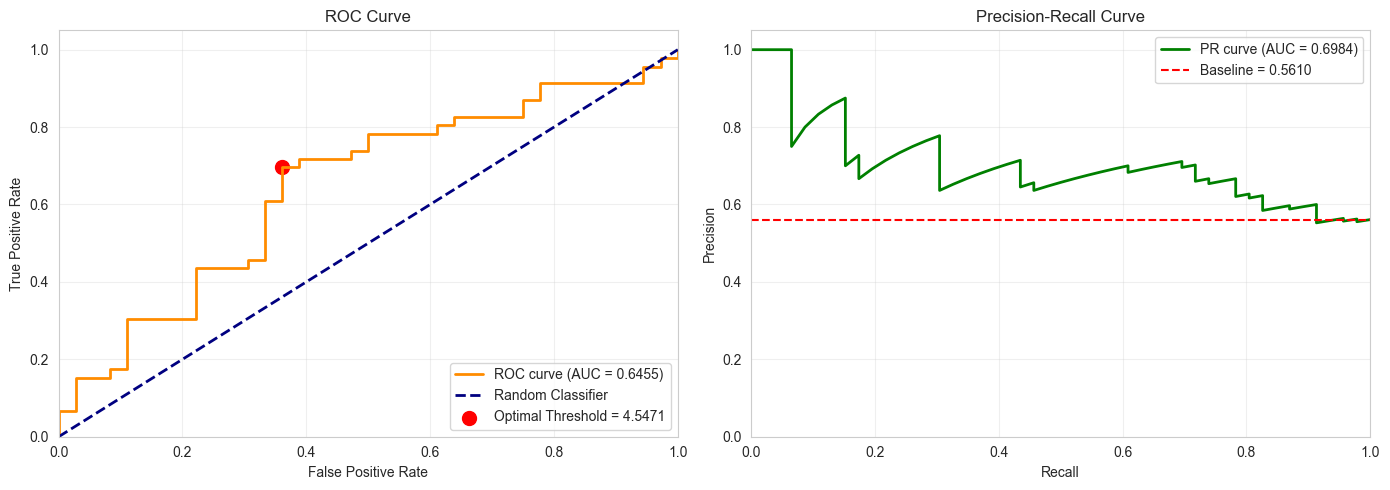

评估曲线已保存到 ambiguity_detection_evaluation.png

PR-AUC (Precision-Recall AUC): 0.6984


In [31]:
# 9. 可视化 ROC 曲线和 Precision-Recall 曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC 曲线
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auroc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, 
                label=f'Optimal Threshold = {optimal_threshold:.4f}')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

axes[1].plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].axhline(y=np.sum(y_true) / len(y_true), color='red', linestyle='--', 
                label=f'Baseline = {np.sum(y_true) / len(y_true):.4f}')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ambiguity_detection_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("评估曲线已保存到 ambiguity_detection_evaluation.png")
print(f"\nPR-AUC (Precision-Recall AUC): {pr_auc:.4f}")